
   Scipy sparse data matrices already exist at ../data/dataset/year__body:  loading them
Loaded data X:(382429, 10000), y:(382429,)  ✅


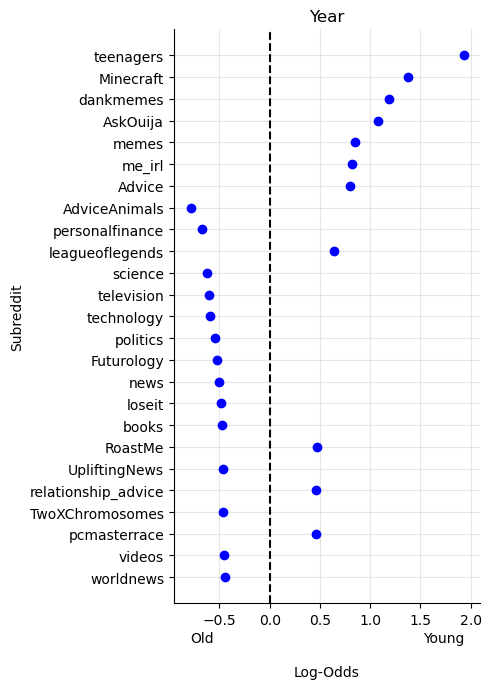

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from pathlib import Path
import yaml
import sys
sys.path += ['../src/']
from utils import load_data

# Define parameters
dimension = "year"  # <-------  Replace with your desired dimension (demo_rep, gender, year)
top_n = 25  # Define the number of top features to plot
PERCENTILE = 0.99

name_dim = "partisan" if dimension == "demo_rep" else dimension
filename = f"log-odds-{name_dim}-PERCENTILE{int(PERCENTILE*1000)}-top{top_n}.pdf"

feature_names = np.load("../data/input/list_subreddits.npy", allow_pickle=True)

with open("../scripts/parameters.yaml", 'r') as stream:
    parameters = yaml.safe_load(stream)
dataset_path = Path(parameters['dataset_path'])
input_path = Path(parameters['input_path'])
X_declarations, _ = load_data(dataset_path / Path(f"{dimension}__body"),
                                                attribute_to_label=None,
                                                input_path=input_path,
                                                use_bool_features=False,
                                                save=True)

# Load all files for the given dimension
files = glob.glob(f"../data/results/log_probs/dimension{dimension}-use_declaration_in_trainTrue-seed*log_prob.npy")

# Read and stack numpy arrays
data_list = [np.load(file) for file in files]
data = np.stack(data_list, axis=0)
l1_norms = np.sum(np.abs(X_declarations), axis=0)

# Calculate average L1 norm
average_l1_norm = np.quantile(np.asarray(l1_norms), PERCENTILE)

# Select features with L1 norm greater than the average
selected_features = np.asarray(l1_norms > average_l1_norm).flatten()

# Filter data and feature names based on selected features
data_filtered = data[:, :, selected_features]
feature_names_filtered = [name for i, name in enumerate(feature_names) if selected_features[i]]

# Convert log probabilities to probabilities for each class
probabilities = np.exp(data_filtered)  # Shape will still be (num_seeds, 2, num_selected_features)

# Calculate log odds for each seed
log_odds = np.log((probabilities[:, 1, :] / (1 - probabilities[:, 1, :])) / 
                  (probabilities[:, 0, :] / (1 - probabilities[:, 0, :])))

# Calculate mean and standard deviation of log odds
mean_log_odds = np.mean(log_odds, axis=0)
std_log_odds = (np.max(log_odds, axis=0) - np.min(log_odds, axis=0)) / 2

# Get indices of the top features
top_indices = np.argsort(np.abs(mean_log_odds))[::-1][:top_n]

# Extract top features and their log odds
top_features = [feature_names_filtered[idx] for idx in top_indices]
top_log_odds = [mean_log_odds[idx] for idx in top_indices]
top_std = [std_log_odds[idx] for idx in top_indices]

# Plotting
plt.figure(figsize=(5, 3 * np.abs(top_n) // 10))
plt.errorbar(top_log_odds[::-1], top_features[::-1], 
             xerr=np.array(top_std[::-1]), fmt='o', color='blue', ecolor='black', elinewidth=1, capsize=0)


# Adding labels and title
plt.ylabel('Subreddit')
plt.xlabel('\n\nLog-Odds')
plt.title(f'{name_dim.capitalize()}')
extreme_left = {'partisan': 'democrat', 'gender': 'male', 'year': 'old'}
extreme_right = {'partisan': 'republican', 'gender': 'female', 'year': 'young'}
plt.text(min(top_log_odds), -3, extreme_left[name_dim].capitalize(), fontsize=10, ha='left')  # Adjust coordinates for your plot range
plt.text(max(top_log_odds), -3, extreme_right[name_dim].capitalize(), fontsize=10, ha='right')  # Adjust coordinates for your plot range



# Adding mean probability line
sns.despine()
plt.axvline(0., color='black', linestyle='--')

plt.grid(alpha=.3)

plt.tight_layout()
plt.savefig(f'../data/figures/{filename}', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
